<a href="https://colab.research.google.com/github/pradeepvaranasi/ecommerce_clv/blob/main/ecommerce_clv_lifetimes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


For this exercise, we’re going to predict future purchasing from a history of customer transactions.

Data represents approximately 50,000 transactions from an ecommerce store that sells widgets



In [ ]:
# installing lifetimes package
!pip install Lifetimes

**placeholder

In [4]:
# importing libraries
import pandas as pd
import numpy as np
import datetime as dt
from operator import attrgetter
from lifetimes import ModifiedBetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix
from lifetimes.plotting import *
from lifetimes.utils import *
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score)
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
# importing data
data = pd.read_csv('data.csv')

In [6]:
# copying the data to dataframe df
df = data.copy()

In [7]:
# checking the first n rows
df.head(2)

,CustomerID,Timestamp,PurchaseValue
0,5611860a94204a4078659f1667372cc4,2017-02-09T18:31:00Z,4.72
1,07b260307114f9cffc5601eb7ad4b565,2017-06-28T19:26:00Z,5.33


In [8]:
# checking the shape of the dataframe
df.shape

(49945, 3)

In [9]:
# checking for duplicates
df.duplicated().sum()

0

In [10]:
# Explore basic characteristics of the data
print("Basic Data Information:")
df.info()

Basic Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49945 entries, 0 to 49944
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     49945 non-null  object 
 1   Timestamp      49945 non-null  object 
 2   PurchaseValue  49945 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


From the above, we could infer
1. There are no missing values in the data
2. There are no duplicate values in the data
3. The *Timestamp* feature should be coverted to datetime object

In [11]:
# reconfirming the missing values in the data
df.isnull().sum()

CustomerID       0
Timestamp        0
PurchaseValue    0
dtype: int64

In [12]:
# Timestamp feature conversion to datatime object
df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.date
df.head(2)

,CustomerID,Timestamp,PurchaseValue
0,5611860a94204a4078659f1667372cc4,2017-02-09,4.72
1,07b260307114f9cffc5601eb7ad4b565,2017-06-28,5.33


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49945 entries, 0 to 49944
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     49945 non-null  object 
 1   Timestamp      49945 non-null  object 
 2   PurchaseValue  49945 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [14]:
# descriptive stats for the PurchaseValue feature
df['PurchaseValue'].describe()

count    49945.000000
mean       236.888196
std        245.760987
min          4.720000
25%         97.100000
50%        166.660000
75%        286.790000
max      11599.680000
Name: PurchaseValue, dtype: float64

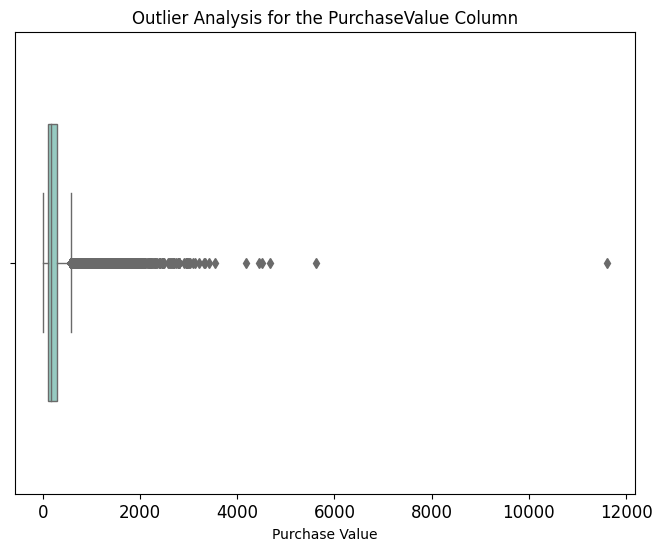

In [15]:
# Create a boxplot
plt.figure(figsize=(8, 6))  # Adjust the figure size

# Customize the color palette for better visibility
sns.set_palette("Set3")

# Increase the linewidth of the box and whiskers
sns.boxplot(x=df['PurchaseValue'], linewidth=1, width=0.6)

# Set labels and title
plt.xlabel('Purchase Value')
plt.title('Outlier Analysis for the PurchaseValue Column')

# Customize tick labels for better readability
plt.xticks(fontsize=12)

# Show the plot
plt.show()

In [16]:
df.head(2)

,CustomerID,Timestamp,PurchaseValue
0,5611860a94204a4078659f1667372cc4,2017-02-09,4.72
1,07b260307114f9cffc5601eb7ad4b565,2017-06-28,5.33


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49945 entries, 0 to 49944
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     49945 non-null  object 
 1   Timestamp      49945 non-null  object 
 2   PurchaseValue  49945 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [18]:
df['Timestamp'].max()

datetime.date(2017, 12, 6)

In [19]:
# Convert CustomerID to integer values
# df['CustomerID'] = pd.factorize(df['CustomerID'])[0]

In [20]:
# Create rfm data for Lifetimes
max_date = df['Timestamp'].max()

rfm = df.groupby('CustomerID').agg({'Timestamp': lambda x: (max_date - x.max()).days,
                                    'CustomerID': lambda x: x.count(),
                                    'PurchaseValue': lambda x: x.sum()})

rfm.columns = ['recency', 'frequency', 'monetary']
rfm = rfm.reset_index()
rfm.head()

,CustomerID,recency,frequency,monetary
0,0001117ff1305c1fe840697166e61564,333,2,175.53
1,00028502859fd7e111d88c20456b59d5,342,1,78.10
2,000306d200fd6e9b03de48d15348f5c2,33,1,98.44
3,0003f3458a6e7b495a975c2d9ddda559,58,3,244.41
4,000784b838b807ad589d4bc69c0c562f,210,1,85.78


CLTV

In [21]:
# calculate the cltv for the base data

cltv_df = df.groupby("CustomerID").agg(
    {
        "Timestamp": [
            lambda x: (x.max() - x.min()).days,
            lambda x: (max_date - x.min()).days,
        ],
        "CustomerID": "count",
        "PurchaseValue": "sum",
    }
)

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ["recency", "T", "frequency", "monetary"]
cltv_df = cltv_df.reset_index()
cltv_df.head()

,CustomerID,recency,T,frequency,monetary
0,0001117ff1305c1fe840697166e61564,11,344,2,175.53
1,00028502859fd7e111d88c20456b59d5,0,342,1,78.10
2,000306d200fd6e9b03de48d15348f5c2,0,33,1,98.44
3,0003f3458a6e7b495a975c2d9ddda559,285,343,3,244.41
4,000784b838b807ad589d4bc69c0c562f,0,210,1,85.78


In [22]:
cltv_df.shape

(23708, 5)

In [23]:
#Average Order Value
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

#Recency & Tenure
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

#Frequency
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

In [24]:
cltv_df.shape

(10051, 5)

Model Building

In [25]:
BGF = BetaGeoFitter(penalizer_coef=0.001)  # avoid overfitting

BGF.fit(cltv_df["frequency"], cltv_df["recency"], cltv_df["T"])

<lifetimes.BetaGeoFitter: fitted with 10051 subjects, a: 1.08, alpha: 8.64, b: 4.61, r: 2.06>

In [26]:
BGF.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.059494,0.056194,1.949354,2.169634
alpha,8.636019,0.320852,8.007150,9.264888
a,1.077864,0.031440,1.016241,1.139487
b,4.607810,0.126514,4.359843,4.855778


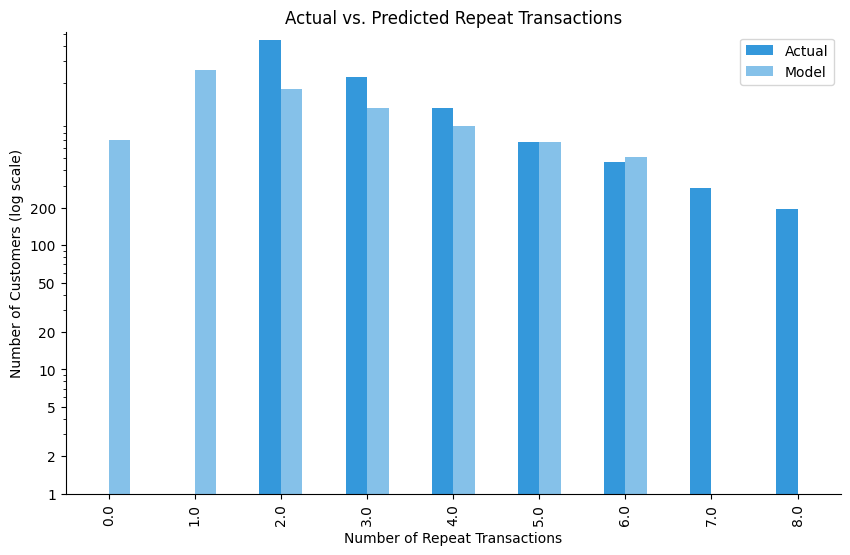

In [33]:
import seaborn as sns
from lifetimes.plotting import plot_period_transactions
from matplotlib.ticker import ScalarFormatter

# plotting BetaGeoFitter model
ax = plot_period_transactions(BGF, max_frequency=7, figsize=(10, 6),  color=['#3498db', '#85c1e9', '#ccd1d1'])
ax.set_yscale('log')

# defining y-axis ticks and labels
ax.set_yticks([1, 2, 5, 10, 20, 50, 100, 200])
ax.get_yaxis().set_major_formatter(ScalarFormatter())

# setting labels and title
ax.set_xlabel('Number of Repeat Transactions')
ax.set_ylabel('Number of Customers (log scale)')
ax.set_title('Actual vs. Predicted Repeat Transactions')

sns.despine();

1 week

In [28]:
BGF.conditional_expected_number_of_purchases_up_to_time(
    1, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"]
).sort_values(ascending=False).head(10).to_frame(
    "Expected Number of Transactions"
).reset_index()

,index,Expected Number of Transactions
0,15336,2.187806
1,18747,1.106573
2,6716,0.886645
3,14705,0.841137
4,8831,0.617730
5,5479,0.615234
6,13047,0.573083
7,10926,0.556069
8,3649,0.553156
9,4470,0.540112
